#### 1. Installing the required python packages

In [0]:
!python -m pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 946 kB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4


In [0]:
!pip install -r requirements38.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 146.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 56.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/

In [0]:
!pip install azure-storage-file-datalake
!pip install adlfs
!pip install fsspec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.8/238.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.2/383.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.6/172.6 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-782d2d92-2f83-4632-91c8-5cbcdd711009
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 2.8 MB/s

#### 2. Importing the required python packages

In [0]:
import multiprocessing as mp
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ast import literal_eval

In [0]:
print(f'Started at {datetime.now()}')

Started at 2022-12-28 14:57:10.596134


#### 3. Connect to Azure Data Storage

In [0]:
import os, uuid, sys
from azure.storage.filedatalake import DataLakeServiceClient
from azure.core._match_conditions import MatchConditions
from azure.storage.filedatalake._models import ContentSettings
from azure.storage.blob import BlobServiceClient

In [0]:
def initialize_storage_account(storage_account_name, storage_account_key):
    
    try:  
        global service_client

        service_client = DataLakeServiceClient(account_url="{}://{}.dfs.core.windows.net".format(
            "https", storage_account_name), credential=storage_account_key)
    
    except Exception as e:
        print(e)

In [0]:
storage_account = "legoaistorage"
storage_account_key = "vOHAjE9vOHaxqmTRxIYETQbYlPvvFpJQ7xfky8tuWBRE9E6IbfM87ERkGcqqiHfMHs+WnEt907r6+AStjIYXlA=="
initialize_storage_account(storage_account,storage_account_key)

In [0]:
### Spark Configuration
spark.conf.set("fs.azure.account.key."+ storage_account +".dfs.core.windows.net", storage_account_key)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [0]:
prefix_path = "abfss://datascience-dataset@legoaistorage.dfs.core.windows.net/"

In [0]:
filepath = 'Model_Data/labelled_model_data.csv'
filepath_upd = prefix_path + filepath
model_data_spark = spark.read.format("csv").option("header","true").load(filepath_upd)
model_data = model_data_spark.toPandas()

In [0]:
filepath = 'Model_Data/feats_col_name.csv'
filepath_upd = prefix_path + filepath
col_name = spark.read.format("csv").option("header","true").load(filepath_upd)
col_name_data = col_name.toPandas()

In [0]:
upd_cols = [cols.replace('""""','""') for cols in col_name_data['column_name'].tolist()]
upd_cols = [cols.replace('"n_','n_')[:-1] if cols in ['"n_[""]-agg-any"','"n_[""]-agg-all"','"n_[""]-agg-mean"','"n_[""]-agg-var"','"n_[""]-agg-min"','"n_[""]-agg-max"','"n_[""]-agg-median"','"n_[""]-agg-sum"','"n_[""]-agg-kurtosis"','"n_[""]-agg-skewness"'] else cols for cols in upd_cols]
model_data.columns = upd_cols

#### 4. Data Subset & Analysis

In [0]:
### Datatype Mapping
datatype_mapping = {
    'Open_ended_Short_text': 'Open_ended_short_text',
    'Open_ended_Long_text':'Open_ended_long_text',
    'others':'Other',
    'Long_Interger':'Long_Integer',
    'Close_ended_long_text':'Open_ended_long_text'
    }

model_data = model_data.replace({'label':datatype_mapping})

In [0]:
#### Removing the datatype with is of "Other" type
model_data_non_other = model_data[model_data['label']!='Other']

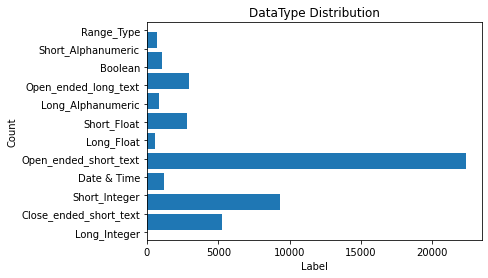

In [0]:
### Label Frequency Distribution
plt.hist(model_data_non_other['label'],orientation='horizontal',rwidth=0.8)
plt.title('DataType Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

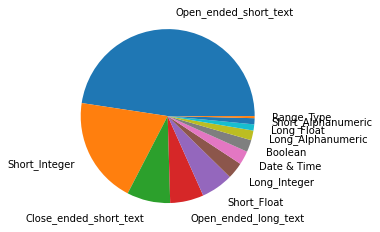

In [0]:
### Label Frequency Distribution
plt.pie(model_data_non_other['label'].value_counts(),labels=model_data_non_other['label'].value_counts().index,labeldistance=1.2)
plt.show()

#### 5. Train-Test Data Split and Subset

In [0]:
### Subsetting the required columns
ignore_cols = ['id','table_name','column_name','start_time','end_time','execution_time','file_name']
model_data_subset = model_data_non_other[[cols for cols in model_data_non_other.columns if cols not in ignore_cols]]

In [0]:
char_col = [cols for cols in model_data_subset.columns if 'n_[' in cols]
par_col = [cols for cols in model_data_subset.columns if 'par_vec_' in cols]
word_col = [cols for cols in model_data_subset.columns if 'word_embedding_' in cols]
rest_col = [cols for cols in model_data_subset.columns if cols not in set(char_col).union(set(par_col)).union(set(word_col)) and cols not in['label','uniq_id','model_type'] and cols not in ['repo_name']] 
feats_cols = list(char_col+par_col+word_col+rest_col)

In [0]:
### Features conversion to Float type
model_data_subset[feats_cols] = model_data_subset[feats_cols].astype("float32")

/local_disk0/.ephemeral_nfs/envs/pythonEnv-782d2d92-2f83-4632-91c8-5cbcdd711009/lib/python3.9/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [0]:
model_data_subset['label'].unique()

Out[21]: array(['Long_Integer', 'Close_ended_short_text', 'Short_Integer',
       'Date & Time', 'Open_ended_short_text', 'Long_Float',
       'Short_Float', 'Long_Alphanumeric', 'Open_ended_long_text',
       'Boolean', 'Short_Alphanumeric', 'Range_Type'], dtype=object)

#### Train Test Data Split

In [0]:
### Train/Test Data
train_val_data = model_data_subset[model_data_subset['repo_name'].isin(['sherlock','web_data_common','swastik'])]
test_data = model_data_subset[~model_data_subset['repo_name'].isin(['sherlock','web_data_common','swastik'])]

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
train_val_data['le_encoded'] = le.fit_transform(train_val_data['label'])

<command-381651783246978>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_val_data['le_encoded'] = le.fit_transform(train_val_data['label'])


In [0]:
### New train/Valid Split
# train_data,valid_data = train_test_split(train_val_data,train_size=0.8,stratify=train_val_data['le_encoded'])

### Existing train/Valid Split
filepath = 'Model_Results/26122022_XGB/valid_data.csv'
filepath_upd = prefix_path + filepath
valid_data_spark = spark.read.format("csv").option("header","true").load(filepath_upd)
valid_data_df = valid_data_spark.toPandas()
valid_uniq_id = valid_data_df['uniq_id'].unique()

train_data = train_val_data[~train_val_data['uniq_id'].isin(valid_uniq_id)]
valid_data = train_val_data[train_val_data['uniq_id'].isin(valid_uniq_id)]

In [0]:
test_data['le_encoded'] = le.transform(test_data['label'])

<command-1065531786841581>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['le_encoded'] = le.transform(test_data['label'])


In [0]:
train_data.shape, valid_data.shape, test_data.shape

Out[26]: ((30400, 2048), (7600, 2048), (8963, 2048))

#### 6. Model Building

In [0]:
from sklearn.metrics import f1_score, classification_report

In [0]:
sub_feature_cols = feats_cols #char_col+word_col+rest_col
column_mapping = {cols: 'feats_col_'+str(i) for i, cols in enumerate(sub_feature_cols)}

In [0]:
start = datetime.now()
print(f'Started at {start}')

X_train = train_data[sub_feature_cols]
X_train.columns = [column_mapping[cols] for cols in X_train.columns]
y_train = train_data['le_encoded'].values.flatten()

print(f'Load data (train) process took {datetime.now() - start} seconds.')

Started at 2022-12-28 15:13:55.381769
Load data (train) process took 0:00:00.065557 seconds.


In [0]:
print('Distinct types for columns in the Dataframe (should be all float32):')
print(set(X_train.dtypes))

Distinct types for columns in the Dataframe (should be all float32):
{dtype('float32')}


In [0]:
start = datetime.now()
print(f'Started at {start}')

X_validation = valid_data[sub_feature_cols]
X_validation.columns = [column_mapping[cols] for cols in X_validation.columns]
y_validation = valid_data['le_encoded'].values.flatten()

print(f'Load data (validation) process took {datetime.now() - start} seconds.')

Started at 2022-12-28 15:13:55.580779
Load data (validation) process took 0:00:00.019325 seconds.


In [0]:
start = datetime.now()
print(f'Started at {start}')

X_test = test_data[sub_feature_cols]
X_test.columns = [column_mapping[cols] for cols in X_test.columns]
y_test = test_data['le_encoded'].values.flatten()

print(f'Load data (test) process took {datetime.now() - start} seconds.')

Started at 2022-12-28 15:13:55.679889
Load data (test) process took 0:00:00.021984 seconds.


In [0]:
print(X_train.shape,X_test.shape,X_validation.shape)

(30400, 2044) (8963, 2044) (7600, 2044)


In [0]:
set(y_train),set(y_test),set(y_validation)

Out[34]: ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})

#### 6.1. XGBoost Model

In [0]:
# !pip install xgboost

In [0]:
from xgboost import XGBClassifier
import re

clf=XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=500, objective='binary:logistic', booster='gbtree')

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

#Printing all the parameters of XGBoost
print(clf)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [0]:
#Creating the model on Training Data
XGB=clf.fit(X_train,y_train)

##### Model Performance Metrics

In [0]:
### Test Dataset Prediction
prediction_test=XGB.predict(X_test)

In [0]:
y_test_label = [le.inverse_transform([x])[0] for x in y_test.tolist()]
y_validation_label = [le.inverse_transform([x])[0] for x in y_validation.tolist()]
y_train_label = [le.inverse_transform([x])[0] for x in y_train.tolist()]

In [0]:
print(classification_report(y_test_label, prediction_test_label))

                        precision    recall  f1-score   support

               Boolean       0.53      0.12      0.20       934
Close_ended_short_text       0.53      0.80      0.63       826
           Date & Time       0.94      0.75      0.83       439
     Long_Alphanumeric       0.55      0.28      0.37       374
            Long_Float       0.88      0.37      0.52       271
          Long_Integer       0.84      0.77      0.81       643
  Open_ended_long_text       0.91      0.60      0.73       204
 Open_ended_short_text       0.64      0.85      0.73       951
            Range_Type       0.00      0.00      0.00        12
    Short_Alphanumeric       0.24      0.31      0.27       249
           Short_Float       0.49      0.79      0.60       307
         Short_Integer       0.82      0.88      0.84      3753

              accuracy                           0.71      8963
             macro avg       0.61      0.54      0.55      8963
          weighted avg       0.71     

In [0]:
### Validation Dataset Prediction
prediction_validation=XGB.predict(X_validation)

In [0]:
prediction_test_label = [le.inverse_transform([x])[0] for x in prediction_test.tolist()]
prediction_validation_label = [le.inverse_transform([x])[0] for x in prediction_validation.tolist()]

In [0]:
print(classification_report(y_validation_label, prediction_validation_label))

                        precision    recall  f1-score   support

               Boolean       1.00      0.70      0.82        23
Close_ended_short_text       0.83      0.64      0.72       592
           Date & Time       0.94      0.91      0.93       151
     Long_Alphanumeric       0.68      0.53      0.60        95
            Long_Float       0.85      0.64      0.73        53
          Long_Integer       0.89      0.98      0.93       161
  Open_ended_long_text       0.95      0.97      0.96       545
 Open_ended_short_text       0.94      0.97      0.95      4282
            Range_Type       0.85      0.68      0.75        34
    Short_Alphanumeric       0.75      0.47      0.58        57
           Short_Float       0.92      0.84      0.88       499
         Short_Integer       0.92      0.97      0.94      1108

              accuracy                           0.92      7600
             macro avg       0.88      0.77      0.82      7600
          weighted avg       0.92     

In [0]:
### Train Dataset Prediction
prediction_train=XGB.predict(X_train)

In [0]:
prediction_train_label = [le.inverse_transform([x])[0] for x in prediction_train.tolist()]

In [0]:
print(classification_report(y_train_label, prediction_train_label))

                        precision    recall  f1-score   support

               Boolean       1.00      1.00      1.00        92
Close_ended_short_text       0.96      0.84      0.90      2368
           Date & Time       1.00      1.00      1.00       605
     Long_Alphanumeric       1.00      1.00      1.00       379
            Long_Float       1.00      1.00      1.00       214
          Long_Integer       1.00      1.00      1.00       643
  Open_ended_long_text       1.00      1.00      1.00      2179
 Open_ended_short_text       0.98      0.99      0.99     17125
            Range_Type       1.00      1.00      1.00       136
    Short_Alphanumeric       1.00      1.00      1.00       228
           Short_Float       1.00      0.95      0.97      1997
         Short_Integer       0.98      1.00      0.99      4434

              accuracy                           0.98     30400
             macro avg       0.99      0.98      0.99     30400
          weighted avg       0.98     

In [0]:
train_data['predicted_prob'] = [max(pred) for pred in XGB.predict_proba(X_train)]
test_data['predicted_prob'] = [max(pred) for pred in XGB.predict_proba(X_test)]
valid_data['predicted_prob'] = [max(pred) for pred in XGB.predict_proba(X_validation)]

<command-4068762900194165>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['predicted_prob'] = [max(pred) for pred in XGB.predict_proba(X_train)]
<command-4068762900194165>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_prob'] = [max(pred) for pred in XGB.predict_proba(X_test)]
<command-4068762900194165>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [0]:
train_data['predicted_datatype'] = prediction_train_label
test_data['predicted_datatype'] = prediction_test_label
valid_data['predicted_datatype'] = prediction_validation_label

<command-4068762900194163>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['predicted_label'] = prediction_train_label
<command-4068762900194163>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_label'] = prediction_test_label
<command-4068762900194163>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

Out[77]: <AxesSubplot:>

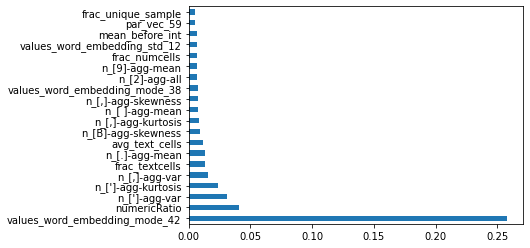

In [0]:
feature_importances = pd.Series(XGB.feature_importances_, index=feats_cols)
feature_importances.nlargest(20).plot(kind='barh')

In [0]:
### Getting the data and other required information from each source
container_name = 'datascience-dataset'
connect_str = 'DefaultEndpointsProtocol=https;AccountName={};AccountKey={}'.format(storage_account,storage_account_key)

In [0]:
def save_df_to_blob(df,output_file):

    try:
        output = df.to_csv(index=False, encoding = "utf-8")
        
        # Instantiate a new BlobClient
        blob_client = container_client.get_blob_client(output_file)
        
        # upload data
        blob_client.upload_blob(output, blob_type="BlockBlob")
        
        return 1
    
    except:
        return 0

##### Writing the results to ADLS

In [0]:
from datetime import datetime
datetime_str = str(datetime.now())[:10].replace('-','')

In [0]:
## Blob storage based configurations
blob_service_client = BlobServiceClient.from_connection_string(connect_str)
container_client = blob_service_client.get_container_client('datascience-dataset/Model_Results/'+datetime_str+'_XGB')

## Train Data
filepath = "train_data.csv"
save_df_to_blob(train_data[['uniq_id','repo_name','label','predicted_label','predicted_prob']],filepath)

## Test Data
filepath = "test_data.csv"
save_df_to_blob(test_data[['uniq_id','repo_name','label','predicted_label','predicted_prob']],filepath)

## Valid Data
filepath = "valid_data.csv"
save_df_to_blob(valid_data[['uniq_id','repo_name','label','predicted_label','predicted_prob']],filepath)

Out[83]: 1

#### Writing the model object to DBFS

In [0]:
import pickle
filepath = '/dbfs/'+datetime_str+'_XGB_model.pkl'
pickle.dump(XGB, open(filepath, 'wb'))

#### 6.2. Keras based Multi Input Model

In [0]:
!pip install tensorflow

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np

In [0]:
input1 = Input(shape=(960,))
input2 = Input(shape=(400,))
input3 = Input(shape=(81,))
input = Concatenate()([input1, input2, input3])
x = Dense(500)(input)
x = Dense(250)(x)
x = Dense(100)(x)
x = Dense(12)(x)
model = Model(inputs=[input1, input2, input3], outputs=x)
model.summary()

In [0]:
model.compile(optimizer = Adam(learning_rate=0.001),loss = 'categorical_crossentropy',metrics=['accuracy'])

In [0]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_validation_cat = tf.keras.utils.to_categorical(y_validation)

In [0]:
model.fit([X_train[[column_mapping[col] for col in char_col]], X_train[[column_mapping[col] for col in par_col]], X_train[[column_mapping[col] for col in rest_col]]], y_train_cat,epochs=10,validation_data=([X_validation[[column_mapping[col] for col in char_col]], X_validation[[column_mapping[col] for col in par_col]], X_validation[[column_mapping[col] for col in rest_col]]],y_validation_cat))

In [0]:
predicted = model.predict([X_test[[column_mapping[col] for col in char_col]], X_test[[column_mapping[col] for col in par_col]], X_test[[column_mapping[col] for col in rest_col]]])

In [0]:
pred_labels = [np.argmax(pred) for pred in predicted]

In [0]:
print(classification_report(y_test,pred_labels))

#### 6.3. Sherlock Model

In [0]:
!pip install tensorflow

[

*** WARNING: max output size exceeded, skipping output. ***

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 870.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3

In [0]:
from sherlock.deploy.model import SherlockModel

In [0]:
model_id = "retrained_sherlock"

In [0]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    BatchNormalization,
    concatenate,
)
from tensorflow.keras.models import Model, model_from_json

from sherlock.deploy import helpers


class SherlockModel:
    def __init__(self):
        self.lamb = 0.0001
        self.do = 0.35
        self.lr = 0.0001

        self.model_files_directory = "model_files/"

    def fit(
        self, X_train: pd.DataFrame, y_train, X_val: pd.DataFrame, y_val, model_id: str
    ):
        if model_id == "sherlock":
            raise ValueError(
                "`model_id` cannot be `sherlock` to avoid overwriting the original model weights."
            )
        num_classes = len(set(y_train))
        
        encoder = LabelEncoder()
        encoder.fit(y_train)

        feature_cols = helpers.categorize_features()

        X_train_char = X_train[feature_cols["char"]]
        X_train_word = X_train[feature_cols["word"]]
        X_train_par = X_train[feature_cols["par"]]
        X_train_rest = X_train[feature_cols["rest"]]
        X_val_char = X_val[feature_cols["char"]]
        X_val_word = X_val[feature_cols["word"]]
        X_val_par = X_val[feature_cols["par"]]
        X_val_rest = X_val[feature_cols["rest"]]

        y_train_int = encoder.transform(y_train)
        y_val_int = encoder.transform(y_val)
        y_train_cat = tf.keras.utils.to_categorical(y_train_int)
        y_val_cat = tf.keras.utils.to_categorical(y_val_int)
        
        callbacks = [EarlyStopping(monitor="val_loss", patience=5)]

        char_model_input, char_model = self._build_char_submodel(X_train_char.shape[1])
        word_model_input, word_model = self._build_word_submodel(X_train_word.shape[1])
        par_model_input, par_model = self._build_par_submodel(X_train_par.shape[1])
        rest_model_input, rest_model = self._build_rest_submodel(X_train_rest.shape[1])

        # Merge submodels and build main network
        merged_model1 = concatenate([char_model, word_model, par_model, rest_model])

        merged_model_output = self._add_main_layers(merged_model1, num_classes)

        model = Model(
            [char_model_input, word_model_input, par_model_input, rest_model_input],
            merged_model_output,
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr),
            loss="categorical_crossentropy",
            metrics=["categorical_accuracy"],
        )

        model.fit(
            [
                X_train_char.values,
                X_train_word.values,
                X_train_par.values,
                X_train_rest.values,
            ],
            y_train_cat,
            validation_data=(
                [
                    X_val_char.values,
                    X_val_word.values,
                    X_val_par.values,
                    X_val_rest.values,
                ],
                y_val_cat,
            ),
            callbacks=callbacks,
            epochs=10,
            batch_size=256,
        )
    
        self.model = model

        _ = helpers._get_categorical_label_encodings(y_train, y_val, model_id)

    def custom_predict(self, X: pd.DataFrame, model_id: str = model_id) -> np.array:
        """Use sherlock model to generate predictions for X.
        Parameters
        ----------
        X
            Featurized dataframe to generate predictions for.
        model_id
            ID of the model used for generating predictions.
        Returns
        -------
        Array with predictions for X.
        """
        y_pred = self.predict_proba(X, model_id)
        y_pred_classes = helpers._proba_to_classes(y_pred, model_id)

        return y_pred_classes

    def predict_proba(self, X: pd.DataFrame, model_id: str = "sherlock") -> np.array:
        """Use sherlock model to generate predictions for X.
        Parameters
        ----------
        X
            Featurized data set to generate predictions for.
        model_id
            Identifier of a trained model to use for generating predictions.
        Returns
        -------
        Array with predictions for X.
        """
        feature_cols_dict = helpers.categorize_features()

        y_pred = self.model.predict(
            [
                X[feature_cols_dict["char"]].values,
                X[feature_cols_dict["word"]].values,
                X[feature_cols_dict["par"]].values,
                X[feature_cols_dict["rest"]].values,
            ]
        )

        return y_pred

    def initialize_model_from_json(
        self, with_weights: bool, model_id: str = "sherlock"
    ):
        """Load model architecture and populate with pretrained weights.
        Parameters
        ----------
        with_weights
            Whether to populate the model with trained weights.
        model_id
            The ID of the model file to build, defaults to `sherlock` for using the
            sherlock model with the original weights.
        """
        # callbacks = [EarlyStopping(monitor="val_loss", patience=5)]

        model_filename = os.path.join(
            self.model_files_directory, f"{model_id}_model.json"
        )
        if not os.path.exists(model_filename):
            raise ValueError(
                f"""
                No model file associated with this ID: {model_id}, was found.
                The desired model should be specified and stored first before it can be used.
                """
            )

        file = open(model_filename, "r")
        model = model_from_json(file.read())
        file.close()

        if with_weights:
            weights_filename = os.path.join(
                self.model_files_directory, f"{model_id}_weights.h5"
            )
            if not os.path.exists(weights_filename):
                raise ValueError(
                    f"""
                    There are no weights associated with this model ID: {model_id}.
                    The desired model should be trained first before it can be initialized.
                    """
                )
            model.load_weights(weights_filename)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr),
            loss="categorical_crossentropy",
            metrics=["categorical_accuracy"],
        )

        self.model = model

    def store_weights(self, model_id: str):
        if model_id == "sherlock":
            raise ValueError(
                "Cannot save model weights with `sherlock` model ID. Choose an alternative."
            )

        weights_filename = os.path.join(
            self.model_files_directory, f"{model_id}_weights.h5"
        )

        self.model.save_weights(weights_filename)

    def _build_char_submodel(self, char_shape):
        n_weights = 300

        char_model_input = Input(shape=(char_shape,))
        char_model1 = BatchNormalization(axis=1)(char_model_input)
        char_model2 = Dense(
            n_weights,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.l2(self.lamb),
        )(char_model1)
        char_model3 = Dropout(self.do)(char_model2)
        char_model4 = Dense(
            n_weights,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.l2(self.lamb),
        )(char_model3)

        return char_model_input, char_model4

    def _build_word_submodel(self, word_shape):
        n_weights = 200

        word_model_input = Input(shape=(word_shape,))
        word_model1 = BatchNormalization(axis=1)(word_model_input)
        word_model2 = Dense(
            n_weights,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.l2(self.lamb),
        )(word_model1)
        word_model3 = Dropout(self.do)(word_model2)
        word_model4 = Dense(
            n_weights,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.l2(self.lamb),
        )(word_model3)

        return word_model_input, word_model4

    def _build_par_submodel(self, par_shape):
        n_weights = 400

        par_model_input = Input(shape=(par_shape,))
        par_model1 = BatchNormalization(axis=1)(par_model_input)
        par_model2 = Dense(
            n_weights,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.l2(self.lamb),
        )(par_model1)
        par_model3 = Dropout(self.do)(par_model2)
        par_model4 = Dense(
            n_weights,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.l2(self.lamb),
        )(par_model3)

        return par_model_input, par_model4

    def _build_rest_submodel(self, rest_shape):

        # Build submodel for remaining features
        rest_model_input = Input(shape=(rest_shape,))
        rest_model1 = BatchNormalization(axis=1)(rest_model_input)

        return rest_model_input, rest_model1

    def _add_main_layers(self, merged_model1, num_classes):
        n_weights = 500

        merged_model2 = BatchNormalization(axis=1)(merged_model1)
        merged_model3 = Dense(
            n_weights,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.l2(self.lamb),
        )(merged_model2)
        merged_model4 = Dropout(self.do)(merged_model3)
        merged_model5 = Dense(
            n_weights,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.l2(self.lamb),
        )(merged_model4)
        merged_model_output = Dense(
            num_classes,
            activation=tf.nn.softmax,
            kernel_regularizer=tf.keras.regularizers.l2(self.lamb),
        )(merged_model5)

        return merged_model_output

In [0]:
start = datetime.now()
print(f'Started at {start}')

model = SherlockModel()
# model.initialize_model_from_json(with_weights=True, model_id="sherlock");

# Model will be stored with ID `model_id`
model.fit(X_train, y_train, X_validation, y_validation, model_id=model_id)

print('Trained and saved new model.')
print(f'Finished at {datetime.now()}, took {datetime.now() - start} seconds')

In [0]:
model.store_weights(model_id=model_id)

In [0]:
predicted_labels = model.custom_predict(X_test)
predicted_labels = np.array([x.lower() for x in predicted_labels])

In [0]:
set(predicted_labels)

In [0]:
print(f'prediction count {len(predicted_labels)}, type = {type(predicted_labels)}')

size=len(y_test)

# Should be fully deterministic too.
f1_score(y_test[:size], predicted_labels[:size], average="weighted")

In [0]:
print(classification_report(y_test, predicted_labels, digits=3))